In [1]:
#access x_hh folder 
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv



In [6]:
folder = '../data/x_hh'
df0 = pd.read_csv(f"{folder}/household_296_hh.csv")
df_CPI = pd.read_csv("../data/1234_model.csv")

df_CPI = df_CPI.iloc[296:400, 1]
#print shape of df CPI
print(df_CPI.shape)


(104,)


In [8]:
folder = '../data/x_hh'
df0 = pd.read_csv(f"{folder}/household_296_hh.csv")
df_CPI = pd.read_csv("../data/1234_model.csv")

#create two sorted df based on all_I and all_w
df0_I = df0.sort_values(by=['all_I'])
df0_w = df0.sort_values(by=['all_W'])
#just pic the CPI column of the df_CPI but only rows 296 to 399
df_CPI = df_CPI.iloc[296:550, 1]
#print(df_CPI)
#print(df0_I,df0_w)
#safe id of each percentile in a list 
id_I = df0_I['hh_id'].tolist()
id_w = df0_w['hh_id'].tolist()
percentiles_I = []
percentiles_W = []
num_slices = 3

slice_size = len(id_I) // num_slices 


for i in range(num_slices):
    start_idx = i * slice_size
    end_idx = (i + 1) * slice_size
    percentiles_I.append(id_I[start_idx:end_idx])
    percentiles_W.append(id_w[start_idx:end_idx])

#print(percentiles_I)
# Initialize dictionaries to store the average of all_I and all_W for each percentile
avg_all_I = {f'Percentile_{i+1}': [] for i in range(num_slices)}
avg_all_W = {f'Percentile_{i+1}': [] for i in range(num_slices)}
#print dimensions of avg_all_I and avg_all_W
#print(len(avg_all_I))

# Loop through each csv file in the x_hh folder
for csv_file in sorted(glob.glob(f"{folder}/household_*_hh.csv")):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    #return the number * in the name from csv_file
    num = int(os.path.basename(csv_file).split('_')[1])


    
    p_value_I = []
    p_value_w = []

    # Calculate the average all_I and all_W for each percentile
    for i, (p_I, p_W) in enumerate(zip(percentiles_I, percentiles_W)):

        avg_I = df[df['hh_id'].isin(p_I)]['all_I'].mean()
        avg_W = df[df['hh_id'].isin(p_W)]['all_W'].mean()

        #rescape both values with CPI by dividing them by CPI[num]
        avg_I = avg_I / df_CPI[num]
        avg_W = avg_W / df_CPI[num]
    

        # Append the averages to the respective percentile keys in the dictionaries
        percentile_key = f'Percentile_{i+1}'
        avg_all_I[percentile_key].append(avg_I)
        avg_all_W[percentile_key].append(avg_W)


# Convert the dictionaries to DataFrames
df_avg_all_I = pd.DataFrame.from_dict(avg_all_I, orient='index').transpose()
df_avg_all_W = pd.DataFrame.from_dict(avg_all_W, orient='index').transpose()

#print(df_avg_all_I,df_avg_all_W)
# Save the DataFrames to CSV files
df_avg_all_I.to_csv(f"{folder}/avg_all_I.csv", index=False)
df_avg_all_W.to_csv(f"{folder}/avg_all_W.csv", index=False)



In [10]:
import glob
import os
import pandas as pd

# Initial setup
folder = '../data/x_hh'
num_slices = 3

# Initialize dictionaries to store the average of all_I and all_W for each percentile
avg_all_I = {f'Percentile_{i+1}': [] for i in range(num_slices)}
avg_all_W = {f'Percentile_{i+1}': [] for i in range(num_slices)}

# Read the CPI data
df_CPI = pd.read_csv("../data/1234_model.csv").iloc[296:550, 1]

gini_coefficients = []
median_incomes = []
median_wealths = []
#print length of df_CPI
#print(len(df_CPI))

#print the number of csv files in the folder
#print(len(glob.glob(f"{folder}/household_*_hh.csv")))

# Loop through each csv file in the folder
for csv_file in sorted(glob.glob(f"{folder}/household_*_hh.csv")):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    # Extract the time step number from the file name
    num = int(os.path.basename(csv_file).split('_')[1])

    # Sort and slice percentiles for this time step
    df_I = df.sort_values(by=['all_I'])
    df_W = df.sort_values(by=['all_W'])
    id_I = df_I['hh_id'].tolist()
    id_W = df_W['hh_id'].tolist()
    percentiles_I = []
    percentiles_W = []

    slice_size = len(id_I) // num_slices
    for i in range(num_slices):
        start_idx = i * slice_size
        end_idx = (i + 1) * slice_size
        percentiles_I.append(id_I[start_idx:end_idx])
        percentiles_W.append(id_W[start_idx:end_idx])
    
    # Calculate Gini Coefficient for income and wealth
    income_array = np.array(df['all_I'])
    wealth_array = np.array(df['all_W'])
    gini_income = np.sum((2 * np.arange(1, income_array.size + 1) - income_array.size - 1) * np.sort(income_array)) / (income_array.size * np.sum(income_array))
    gini_wealth = np.sum((2 * np.arange(1, wealth_array.size + 1) - wealth_array.size - 1) * np.sort(wealth_array)) / (wealth_array.size * np.sum(wealth_array))
    
    gini_coefficients.append({'income': gini_income, 'wealth': gini_wealth})

    # Calculate and store median income and wealth
    median_income = np.median(df['all_I'])
    median_wealth = np.median(df['all_W'])
    median_incomes.append(median_income / df_CPI[num])
    median_wealths.append(median_wealth / df_CPI[num])

    # Calculate and store average values
    for i, (p_I, p_W) in enumerate(zip(percentiles_I, percentiles_W)):
        avg_I = df[df['hh_id'].isin(p_I)]['all_I'].mean()
        avg_W = df[df['hh_id'].isin(p_W)]['all_W'].mean()

        avg_I /= df_CPI[num]
        avg_W /= df_CPI[num]

        percentile_key = f'Percentile_{i+1}'
        avg_all_I[percentile_key].append(avg_I)
        avg_all_W[percentile_key].append(avg_W)

# Convert the dictionaries to DataFrames
df_avg_all_I = pd.DataFrame.from_dict(avg_all_I, orient='index').transpose()
df_avg_all_W = pd.DataFrame.from_dict(avg_all_W, orient='index').transpose()

# Save the DataFrames to CSV files
df_avg_all_I.to_csv(f"{folder}/avg_all_I.csv", index=False)
df_avg_all_W.to_csv(f"{folder}/avg_all_W.csv", index=False)

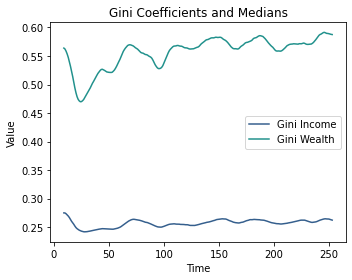

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
vmap = get_cmap('viridis')
import matplotlib.gridspec as gridspec

# Generate some example time steps; replace with your actual time steps if needed
time_steps = list(range(len(gini_coefficients)))

# Extract Gini coefficients for income and wealth from the list of dictionaries
gini_income = [d['income'] for d in gini_coefficients]
gini_wealth = [d['wealth'] for d in gini_coefficients]

#smooth the gini coefficients
gini_income = pd.Series(gini_income).rolling(10).mean()
gini_wealth = pd.Series(gini_wealth).rolling(10).mean()

# #get percentage changes
# gini_income = gini_income.pct_change()
# gini_wealth = gini_wealth.pct_change()



# Create a single plot
fig, ax = plt.subplots(figsize=(5, 4))

# Plot Gini Coefficient for Income
ax.plot(time_steps, gini_income, label='Gini Income', color=vmap(0.3))

# Plot Gini Coefficient for Wealth
ax.plot(time_steps, gini_wealth, label='Gini Wealth', color=vmap(0.5))

# Add a title and labels
ax.set_title('Gini Coefficients and Medians')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
#adjust y axis 
#plt.ylim(0,1)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



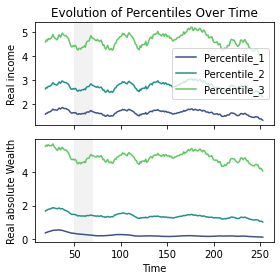

In [12]:
from matplotlib.pyplot import get_cmap
vmap = get_cmap('viridis')
import matplotlib.gridspec as gridspec



df_avg_all_I = pd.read_csv(f"{folder}/avg_all_I.csv")
df_avg_all_W = pd.read_csv(f"{folder}/avg_all_W.csv")
# Compute the relative differences between each subsequent row for Income and Wealth
rel_diff_I = df_avg_all_I.pct_change() * 100  # in percentage
rel_diff_W = df_avg_all_W.pct_change() * 100  # in percentage
#print(rel_diff_I)
# Drop the first row as its relative difference will be NaN
rel_diff_I = rel_diff_I.dropna()
rel_diff_W = rel_diff_W.dropna()
#print(rel_diff_I)
#smooth the data
df_avg_all_I = df_avg_all_I.rolling(window=20).mean()
df_avg_all_W = df_avg_all_W.rolling(window=20).mean()



fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

# Hide the x-axis for the upper plot
ax1.xaxis.set_tick_params(labelbottom=False)

# Color map variable
vmap = plt.get_cmap("viridis")

# Upper plot
for col in df_avg_all_I.columns:
    ax1.plot(df_avg_all_I.index, df_avg_all_I[col], label=col, color=vmap(float(col[11])/4))
ax1.set_ylabel(f'Real income')
ax1.set_title(f'Evolution of Percentiles Over Time')
ax1.legend(loc='right', bbox_to_anchor=(1, 0.5))
ax1.axvspan(50, 70, facecolor='gray', alpha=0.1)
ax1.set_facecolor('white')

# Lower plot
for col in df_avg_all_W.columns:
    ax2.plot(df_avg_all_W.index, df_avg_all_W[col], label=col, color=vmap(float(col[11])/4))
ax2.set_xlabel('Time')
ax2.set_ylabel(f'Real absolute Wealth')

#ax2.legend(loc='right', bbox_to_anchor=(1, 0.5))
ax2.axvspan(50, 70, facecolor='gray', alpha=0.1)
ax2.set_facecolor('white')

plt.tight_layout()
#white backgroun
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

## Run price/taxation shock experiments

The cells below provide the code to replicate the results in the paper. However the user needs to run multiple runs with varying price/taxation shocks and save them in adequate folders in order to run the code below. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

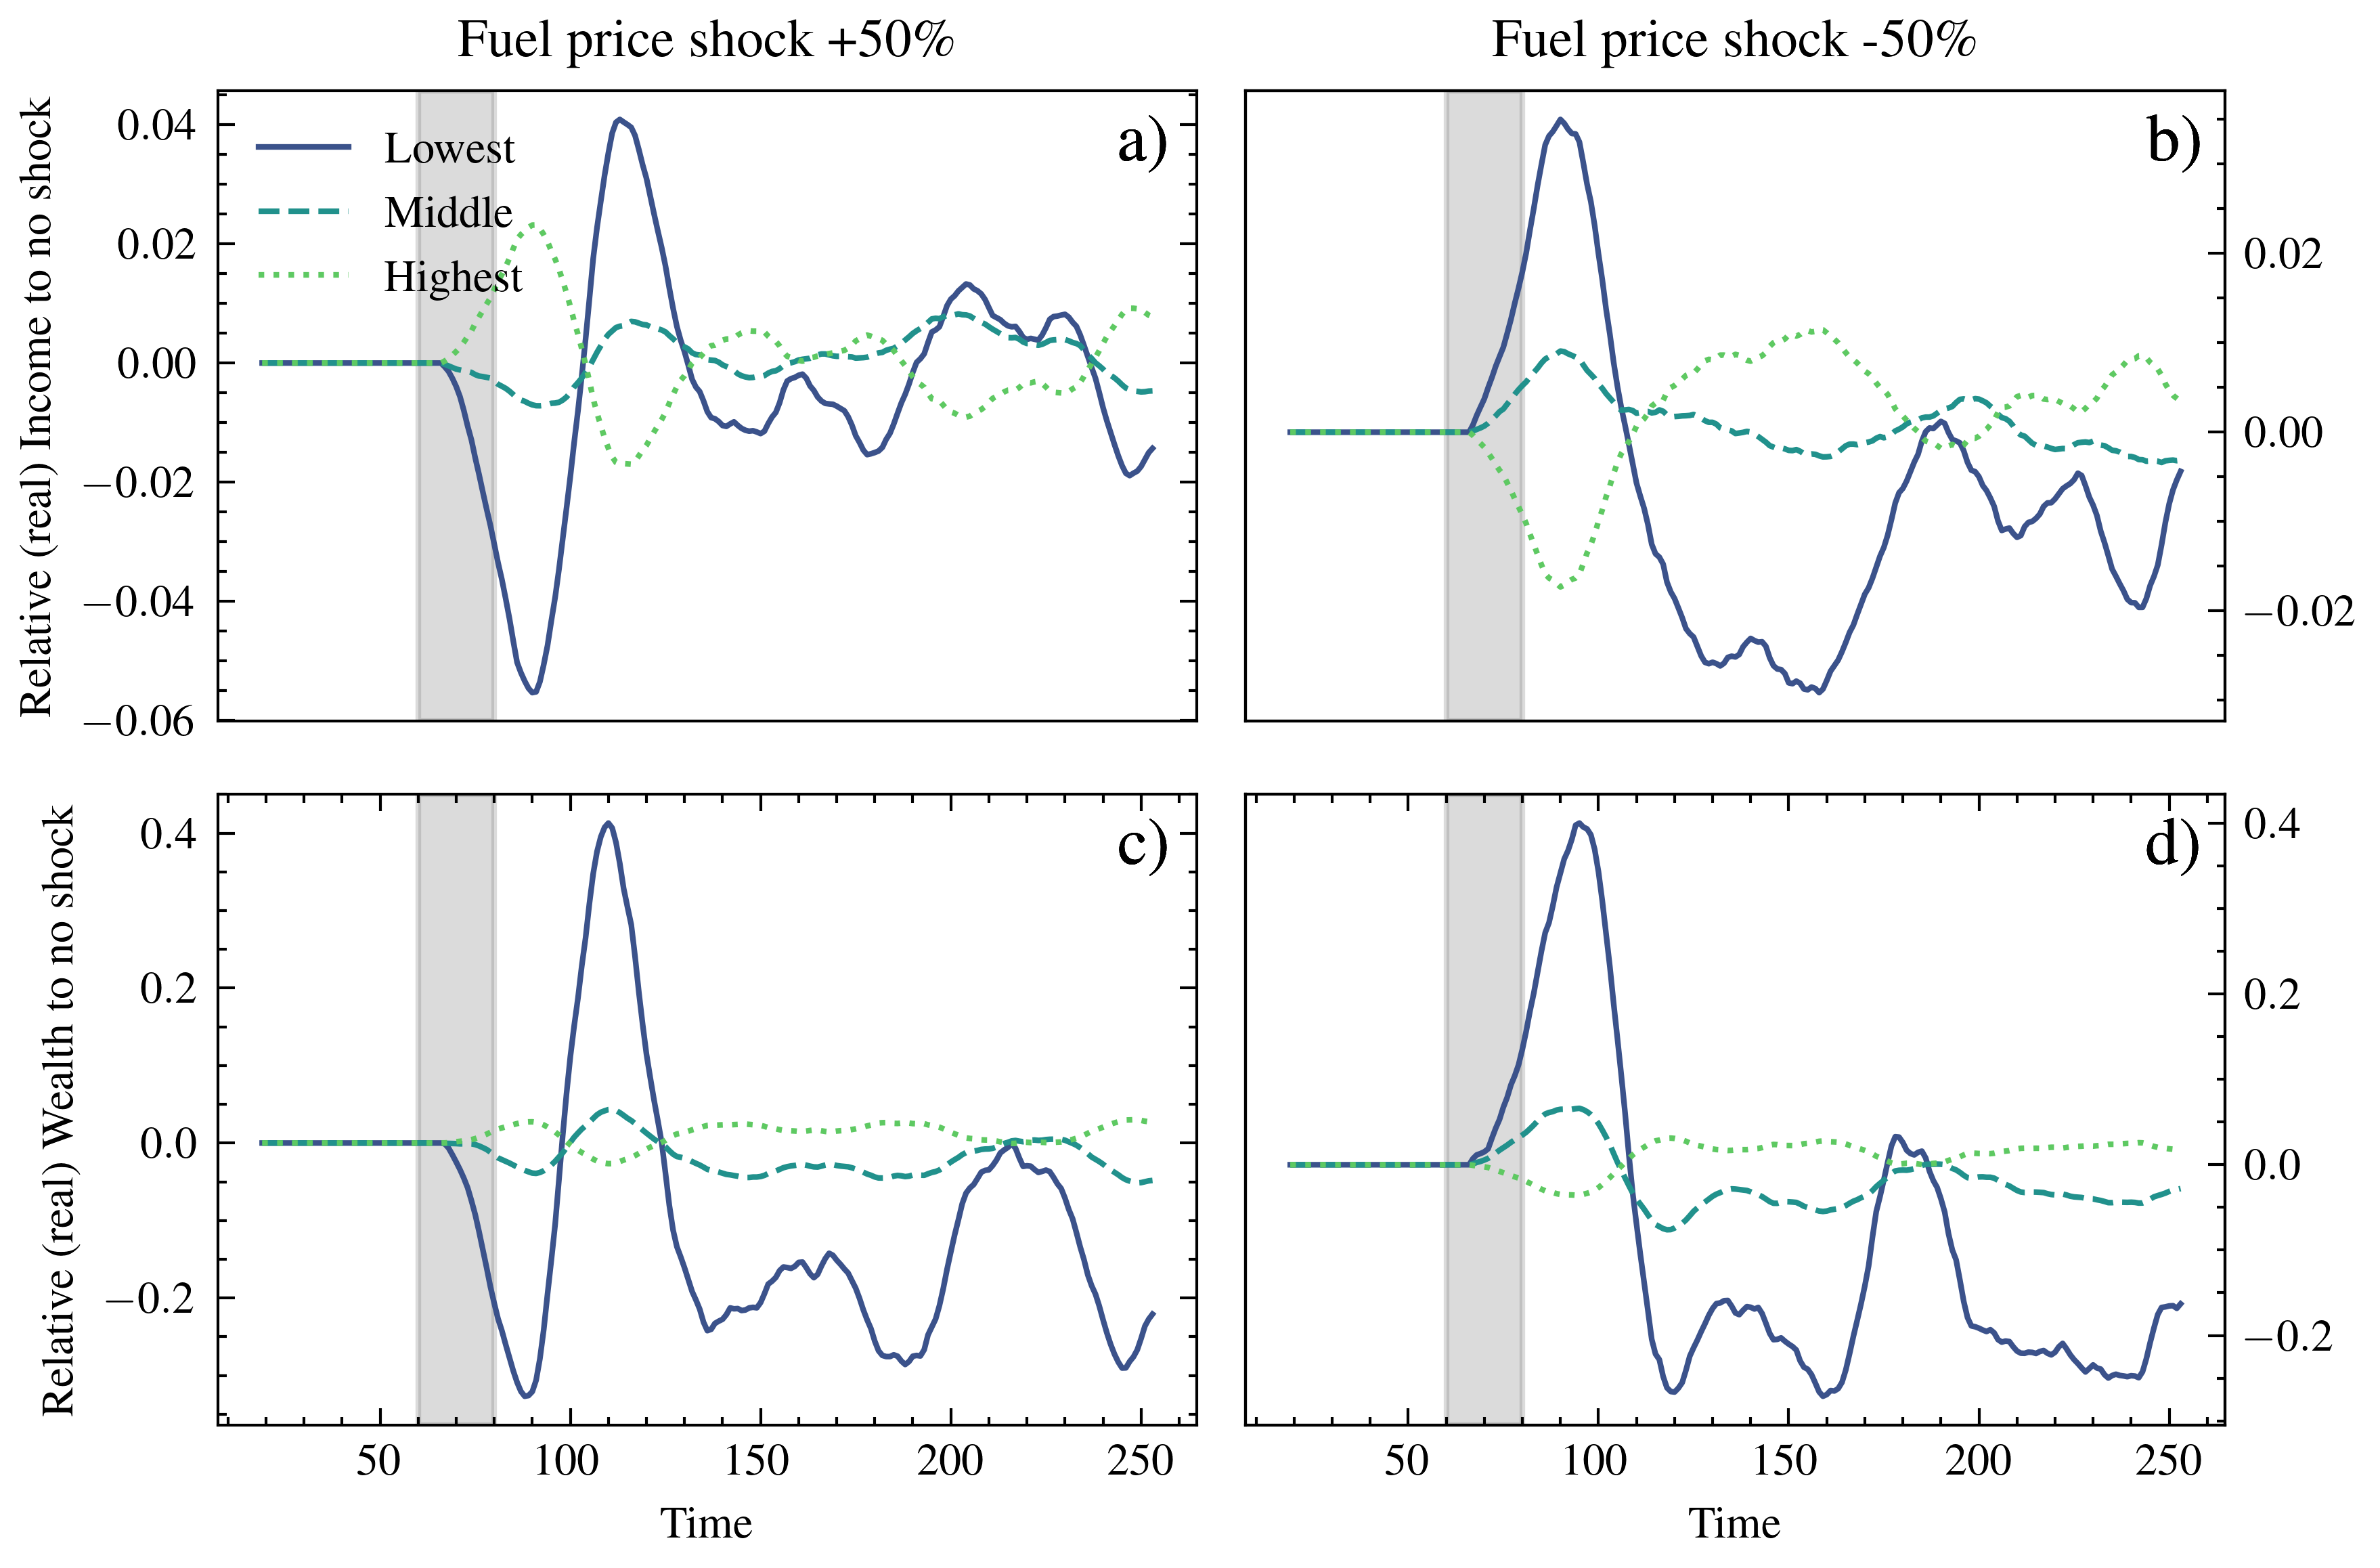

In [30]:
#import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import glob
import math
import scienceplots
from matplotlib.pyplot import get_cmap
vmap = get_cmap('viridis')

def get_percentile_group(col_name):
    # Extract the last string (assuming it's a number) from the column name
    percentile_str = col_name.split("_")[-1]  # Adjust based on your column naming convention
    try:
        percentile = int(percentile_str)
    except ValueError:
        # Handle cases where the conversion to int might fail
        print(f"Could not convert {percentile_str} to an integer.")
        return "Unknown Group"

    # Assigning labels based on the percentile value
    if percentile <= 1:
        return "Lowest "
    elif percentile <= 2:
        return "Middle "
    else:
        return "Highest "

smooth = True
window_size = 10
plt.style.use(['science', 'ieee'])

df_avg_all_I0 = pd.read_csv("x_hh7/avg_all_I.csv")
df_avg_all_W0 = pd.read_csv("x_hh7/avg_all_W.csv")
df_avg_all_I_plus = pd.read_csv("x_hh8/avg_all_I.csv")
df_avg_all_W_plus = pd.read_csv("x_hh8/avg_all_W.csv")
df_avg_all_I_minus = pd.read_csv("x_hh9/avg_all_I.csv")
df_avg_all_W_minus = pd.read_csv("x_hh9/avg_all_W.csv")

#compute the share of overall income and wealth for each percentile
#for this compute the sum of each row and divide each row by the sum of the row
df_avg_all_I_plus['sum'] = df_avg_all_I_plus.sum(axis=1)
df_avg_all_W_plus['sum'] = df_avg_all_W_plus.sum(axis=1)
df_avg_all_I_minus['sum'] = df_avg_all_I_minus.sum(axis=1)
df_avg_all_W_minus['sum'] = df_avg_all_W_minus.sum(axis=1)
df_avg_all_I0['sum'] = df_avg_all_I0.sum(axis=1)
df_avg_all_W0['sum'] = df_avg_all_W0.sum(axis=1)

df_avg_all_I_plus = df_avg_all_I_plus.div(df_avg_all_I_plus['sum'], axis=0)
df_avg_all_W_plus = df_avg_all_W_plus.div(df_avg_all_W_plus['sum'], axis=0)
df_avg_all_I_minus = df_avg_all_I_minus.div(df_avg_all_I_minus['sum'], axis=0)
df_avg_all_W_minus = df_avg_all_W_minus.div(df_avg_all_W_minus['sum'], axis=0)
df_avg_all_I0 = df_avg_all_I0.div(df_avg_all_I0['sum'], axis=0)
df_avg_all_W0 = df_avg_all_W0.div(df_avg_all_W0['sum'], axis=0)

#drop the sum column
df_avg_all_I_plus = df_avg_all_I_plus.drop(columns=['sum'])
df_avg_all_W_plus = df_avg_all_W_plus.drop(columns=['sum'])
df_avg_all_I_minus = df_avg_all_I_minus.drop(columns=['sum'])
df_avg_all_W_minus = df_avg_all_W_minus.drop(columns=['sum'])
df_avg_all_I0 = df_avg_all_I0.drop(columns=['sum'])
df_avg_all_W0 = df_avg_all_W0.drop(columns=['sum'])




#divide each column in df_avg_all_I_plus by the corresponding column in df_avg_all_I0
df_avg_all_I_plus = df_avg_all_I_plus.div(df_avg_all_I0)-1
df_avg_all_W_plus = df_avg_all_W_plus.div(df_avg_all_W0)-1
df_avg_all_I_minus = df_avg_all_I_minus.div(df_avg_all_I0)-1
df_avg_all_W_minus = df_avg_all_W_minus.div(df_avg_all_W0)-1

# Smoothing if needed
if smooth:
    df_avg_all_I_plus = df_avg_all_I_plus.rolling(window=window_size).mean()
    df_avg_all_I_minus = df_avg_all_I_minus.rolling(window=window_size).mean()
    df_avg_all_W_plus = df_avg_all_W_plus.rolling(window=window_size).mean()
    df_avg_all_W_minus = df_avg_all_W_minus.rolling(window=window_size).mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 4))

axes_right_top = axes[0, 1].twinx()
axes_right_bottom = axes[1, 1].twinx()

for col in df_avg_all_I_plus.columns:
    label = get_percentile_group(col)   
    axes[0, 0].plot(df_avg_all_I_plus.index, df_avg_all_I_plus[col], color=vmap(float(col[11])/4),  label=label)
    axes[0, 0].axvspan(60, 80, color='gray', alpha=0.1)


for col in df_avg_all_W_plus.columns:
    axes[1, 0].plot(df_avg_all_W_plus.index, df_avg_all_W_plus[col],color=vmap(float(col[11])/4),   label=f"{col} ")
    axes[1, 0].axvspan(60, 80, color='gray', alpha=0.1)

for col in df_avg_all_I_minus.columns:
    axes_right_top.plot(df_avg_all_I_minus.index, df_avg_all_I_minus[col], color=vmap(float(col[11])/4))
    axes[0, 1].axvspan(60, 80, color='gray', alpha=0.1)

for col in df_avg_all_W_minus.columns:
    axes_right_bottom.plot(df_avg_all_W_minus.index, df_avg_all_W_minus[col], color=vmap(float(col[11])/4))
    axes[1, 1].axvspan(60, 80, color='gray', alpha=0.1)


for ax in axes.flatten():
    ax.legend(loc='right', bbox_to_anchor=(1, 0.5))
    axes[0, 0].legend(loc='upper left', fontsize=8)
    #axes[1, 0].legend(loc='upper left')
    #make title for each column 
    axes[0, 0].set_title(r'Fuel price shock +50\%')
    axes[0, 1].set_title(r'Fuel price shock -50\%')
    #make ylabel for each row
    axes[0, 0].set_ylabel('Relative (real) Income to no shock')
    axes[1, 0].set_ylabel('Relative (real) Wealth to no shock')
    #omit x axis in the first row
    axes[0, 0].get_xaxis().set_visible(False)
    axes[0, 1].get_xaxis().set_visible(False)
    #omit y axis in the second column
    axes[0, 1].get_yaxis().set_visible(False)
    axes[1, 1].get_yaxis().set_visible(False)
    #set x axis label for the second row
    axes[1, 0].set_xlabel('Time')
    axes[1, 1].set_xlabel('Time')
    #omit legend everywhere
    axes[1, 1].legend().set_visible(False)
    axes[1, 0].legend().set_visible(False)
    axes[0, 1].legend().set_visible(False)
    axes[0, 0].text(0.92, 0.96, 'a)', transform=axes[0, 0].transAxes, fontsize=12, fontweight='bold', va='top')
    axes[0, 1].text(0.92, 0.96, 'b)', transform=axes[0, 1].transAxes, fontsize=12, fontweight='bold', va='top')
    axes[1, 0].text(0.92, 0.96, 'c)', transform=axes[1, 0].transAxes, fontsize=12, fontweight='bold', va='top')
    axes[1, 1].text(0.92, 0.96, 'd)', transform=axes[1, 1].transAxes, fontsize=12, fontweight='bold', va='top')


fig.patch.set_facecolor('white')
dpi_value = 600  # Adjust this value as needed for higher or lower resolution
fig.savefig('incomeshocks.png', dpi=dpi_value)

plt.tight_layout()
plt.show()
